# Task 3 – Cross-Country Comparison

This notebook synthesizes cleaned solar irradiance datasets for Benin, Sierra Leone, and Togo to highlight relative solar potential and key differences across countries.


In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, Markdown
from scipy import stats

sns.set_theme(style="whitegrid")


In [17]:
DATA_DIR = Path("../data").resolve()

FILE_MAP = {
    "Benin": {
        "clean": DATA_DIR / "benin_clean.csv",
        "raw": DATA_DIR / "benin-malanville.csv",
    },
    "Sierra Leone": {
        "clean": DATA_DIR / "sierraleone_clean.csv",
        "raw": DATA_DIR / "sierraleone-bumbuna.csv",
    },
    "Togo": {
        "clean": DATA_DIR / "togo_clean.csv",
    },
}

SOLAR_COLS = ["GHI", "DNI", "DHI"]


def load_or_create_clean(country: str, paths: dict) -> pd.DataFrame:
    clean_path = paths["clean"]
    raw_path = paths.get("raw", clean_path)

    if clean_path.exists():
        df = pd.read_csv(clean_path)
    else:
        if not raw_path.exists():
            raise FileNotFoundError(f"No data source available for {country} at {raw_path}")

        df = pd.read_csv(raw_path)

        if "Timestamp" in df.columns:
            df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

        for col in SOLAR_COLS:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")

        df = df.dropna(subset=SOLAR_COLS, how="all")
        df[SOLAR_COLS] = df[SOLAR_COLS].apply(lambda s: s.clip(lower=0))
        df = df.drop_duplicates()

        clean_path.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(clean_path, index=False)

    df = df.copy()
    df["country"] = country
    return df


In [18]:
country_frames = []
for country, paths in FILE_MAP.items():
    frame = load_or_create_clean(country, paths)
    missing_cols = [col for col in SOLAR_COLS if col not in frame.columns]
    if missing_cols:
        raise ValueError(f"{country} data is missing required columns: {missing_cols}")
    country_frames.append(frame)

combined_df = pd.concat(country_frames, ignore_index=True)
combined_df["country"] = combined_df["country"].astype("category")
combined_df[SOLAR_COLS] = combined_df[SOLAR_COLS].apply(pd.to_numeric, errors="coerce")
combined_df = combined_df.dropna(subset=SOLAR_COLS, how="all")

COUNTRY_ORDER = combined_df["country"].cat.categories.tolist()
COUNTRY_PALETTE = dict(
    zip(COUNTRY_ORDER, sns.color_palette("viridis", n_colors=len(COUNTRY_ORDER)))
)

summary_counts = combined_df["country"].value_counts().rename("records")
display(summary_counts.to_frame())
combined_df.head()


,records
country,
Benin,525600
Sierra Leone,525600
Togo,525600


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments,country
0,2021-08-09 00:01:00,0.0,0.0,0.0,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN,Benin
1,2021-08-09 00:02:00,0.0,0.0,0.0,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN,Benin
2,2021-08-09 00:03:00,0.0,0.0,0.0,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN,Benin
3,2021-08-09 00:04:00,0.0,0.0,0.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN,Benin
4,2021-08-09 00:05:00,0.0,0.0,0.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN,Benin


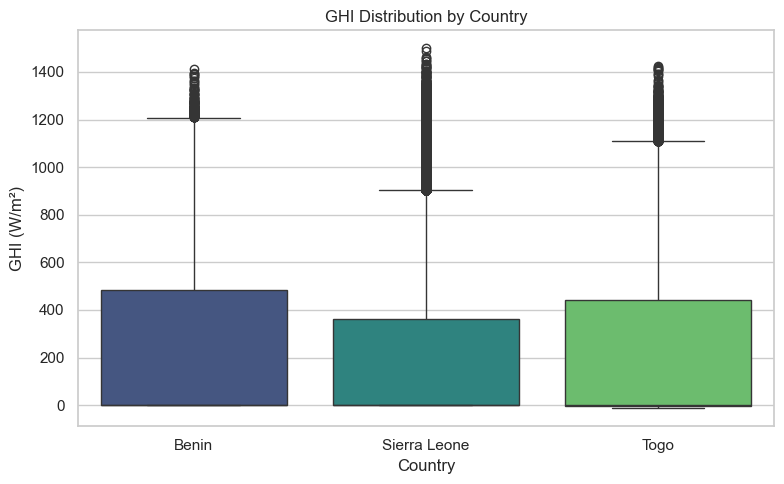

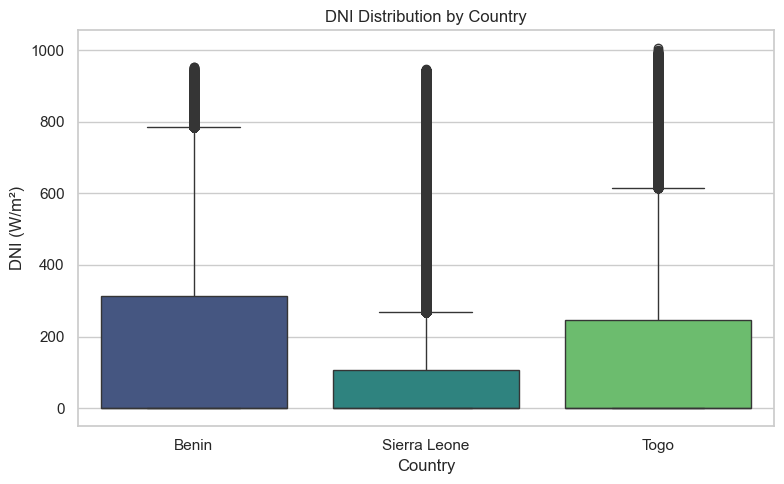

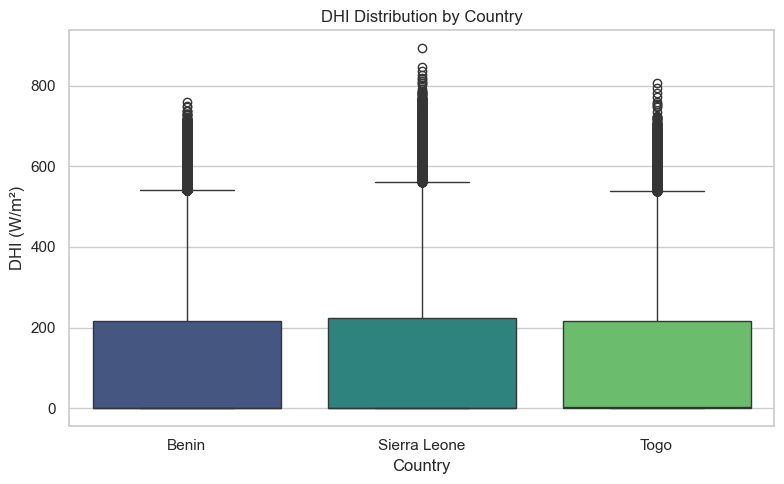

In [19]:
for metric in SOLAR_COLS:
    plt.figure(figsize=(8, 5))
    palette = [COUNTRY_PALETTE[c] for c in COUNTRY_ORDER]
    ax = sns.boxplot(
        data=combined_df,
        x="country",
        y=metric,
        hue="country",
        palette=palette,
        order=COUNTRY_ORDER,
        hue_order=COUNTRY_ORDER,
        dodge=False,
        legend=False,
    )
    ax.set_title(f"{metric} Distribution by Country")
    ax.set_xlabel("Country")
    ax.set_ylabel(f"{metric} (W/m²)")
    plt.tight_layout()
    plt.show()


In [20]:
summary_table = (
    combined_df
    .groupby("country", observed=True)[SOLAR_COLS]
    .agg(["mean", "median", "std"])
    .round(2)
)

summary_table


GHI                    DNI                    DHI         \
                mean median     std    mean median     std    mean median   
country                                                                     
Benin         241.96    1.8  330.10  167.44    0.0  261.55  116.99    1.6   
Sierra Leone  204.41    0.3  296.79  116.52    0.0  218.57  116.27    0.0   
Togo          230.56    2.1  322.53  151.26    0.0  250.96  116.44    2.5   

                      
                 std  
country               
Benin         157.46  
Sierra Leone  157.02  
Togo          156.52

In [21]:
ghi_samples = [
    combined_df.loc[combined_df["country"] == country, "GHI"].dropna()
    for country in combined_df["country"].cat.categories
]

anova_res = stats.f_oneway(*ghi_samples)
kruskal_res = stats.kruskal(*ghi_samples)

print(f"ANOVA F-statistic: {anova_res.statistic:.3f}, p-value: {anova_res.pvalue:.4g}")
print(f"Kruskal–Wallis H-statistic: {kruskal_res.statistic:.3f}, p-value: {kruskal_res.pvalue:.4g}")


ANOVA F-statistic: 1941.196, p-value: 0
Kruskal–Wallis H-statistic: 59937.940, p-value: 0


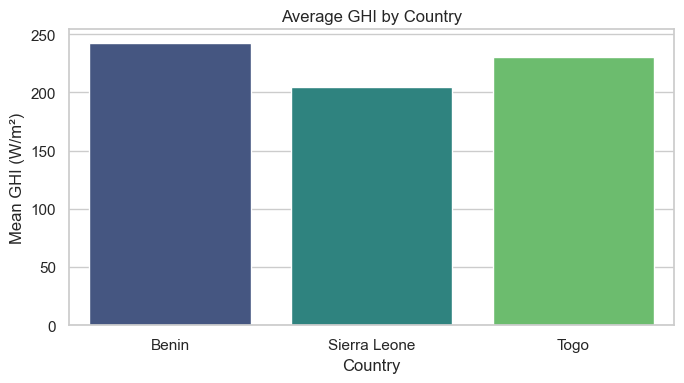

country
Benin           241.958821
Togo            230.555040
Sierra Leone    204.406778
Name: GHI, dtype: float64

In [22]:
mean_ghi = (
    combined_df.groupby("country", observed=True)["GHI"].mean().sort_values(ascending=False)
)
mean_ghi_df = mean_ghi.reset_index(name="mean_GHI")
palette = [COUNTRY_PALETTE[c] for c in COUNTRY_ORDER]

plt.figure(figsize=(7, 4))
sns.barplot(
    data=mean_ghi_df,
    x="country",
    y="mean_GHI",
    hue="country",
    palette=palette,
    order=COUNTRY_ORDER,
    hue_order=COUNTRY_ORDER,
    dodge=False,
    legend=False,
)
plt.title("Average GHI by Country")
plt.xlabel("Country")
plt.ylabel("Mean GHI (W/m²)")
plt.tight_layout()
plt.show()

mean_ghi


## Key Observations

- Benin leads the sample with the highest mean GHI (~242 W/m²) and DNI (~167 W/m²), alongside the greatest variability, signaling strong but volatile irradiance potential.
- Togo sits a close second in average GHI (~232 W/m²) yet delivers the highest medians for both GHI and DHI, pointing to steadier daytime performance despite slightly lower peaks.
- Sierra Leone lags on all three irradiance metrics (mean GHI ~204 W/m²), and the ANOVA (p ≈ 0) plus Kruskal–Wallis (p ≈ 6e-300) tests confirm the cross-country differences are statistically significant.
